# GRAPE calculation of control fields for single-qubit rotation

Robert Johansson (robert@riken.jp)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

In [2]:
from qutip import *
from qutip_qip.operations import rx, rz

In [3]:
T = 1
times = np.linspace(0, T, 100)

In [4]:
theta, phi = np.random.rand(2)

In [5]:
# target unitary transformation (random single qubit rotation)
U = rz(phi) * rx(theta); U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.98923586-0.11638097j -0.01036397-0.08809349j]
 [ 0.01036397-0.08809349j  0.98923586+0.11638097j]]

In [6]:
R = 150
H_ops = [sigmax(), sigmay(), sigmaz()]

H_labels = [r'$u_{x}$',
            r'$u_{y}$',
            r'$u_{z}$',
        ]

In [7]:
H0 = 0 * pi * sigmaz()

# GRAPE

In [8]:
from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.grape import cy_grape_unitary
from qutip.ui.progressbar import TextProgressBar

In [9]:
u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

In [10]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*pi/T, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:   5.94s. Est. time left: 00:00:00:53
20.0%. Run time:  10.97s. Est. time left: 00:00:00:43
30.0%. Run time:  15.85s. Est. time left: 00:00:00:36
40.0%. Run time:  20.60s. Est. time left: 00:00:00:30
50.0%. Run time:  27.20s. Est. time left: 00:00:00:27
60.0%. Run time:  36.50s. Est. time left: 00:00:00:24
70.0%. Run time:  45.72s. Est. time left: 00:00:00:19
80.0%. Run time:  54.55s. Est. time left: 00:00:00:13
90.0%. Run time:  66.32s. Est. time left: 00:00:00:07
Total run time:  74.02s


## Plot control fields for iSWAP gate in the presense of single-qubit tunnelling

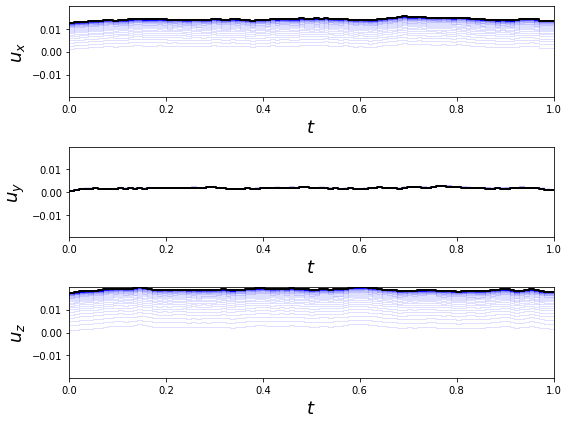

In [11]:
plot_grape_control_fields(times, result.u[:,:,:] / (2 * pi), H_labels, uniform_axes=True);

In [12]:
# target unitary
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.98923586-0.11638097j -0.01036397-0.08809349j]
 [ 0.01036397-0.08809349j  0.98923586+0.11638097j]]

In [13]:
# unitary from grape pulse
result.U_f

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.98923586-0.11638097j -0.01036397-0.08809349j]
 [ 0.01036397-0.08809349j  0.98923586+0.11638097j]]

In [14]:
# target / result overlap
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f))**2

(1.0000000000000004, 1.0000000000000009)

### Verify correctness of the Hamiltonian pulses by integration

In [15]:
c_ops = []

In [16]:
U_f_numerical = propagator(result.H_t, times, c_ops, args={})

In [17]:
U_f_numerical

array([Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
       Qobj data =
       [[1. 0.]
        [0. 1.]]                                                                    ,
       Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
       Qobj data =
       [[ 9.99999101e-01-0.00108678j -3.63741219e-05-0.00078514j]
        [ 3.63741219e-05-0.00078514j  9.99999101e-01+0.00108678j]]                   ,
       Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
       Qobj data =
       [[ 9.99996337e-01-0.00219017j -8.81866171e-05-0.0015878j ]
        [ 8.81866171e-05-0.0015878j   9.99996337e-01+0.00219017j]]                   ,
       Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
       Qobj data =
       [[ 9.99991613e-01-0.00331323j -1.60090822e-04-0.00240225j]
        [ 1.60090822e-04-0.00240225j  9.99991613e-01+0.00331323j]]                   ,
       Quantum objec

In [18]:
_overlap(U, U_f_numerical[-1])

0.9999999987568109

# Bloch sphere dynamics

In [19]:
psi0 = basis(2, 0)
e_ops = [sigmax(), sigmay(), sigmaz()]

In [20]:
me_result = mesolve(result.H_t, psi0, times, c_ops, e_ops)

In [21]:
b = Bloch()

b.add_points(me_result.expect)

b.add_states(psi0)
b.add_states(U * psi0)
b.render()

# Process tomography

## Ideal gate

In [22]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
op_label = [["i", "x", "y", "z"]]

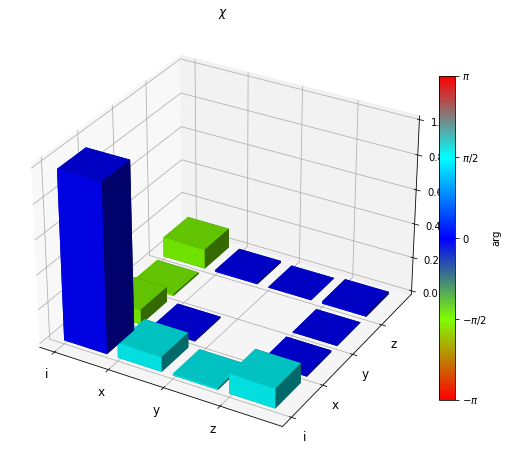

In [23]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(U) * spost(U.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Gate calculated using GRAPE

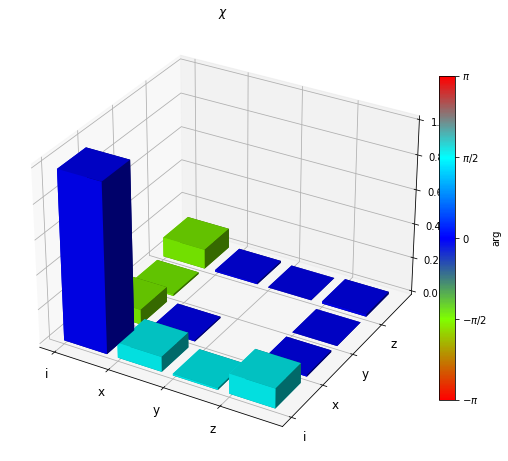

In [24]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(result.U_f) * spost(result.U_f.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Versions

In [25]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,5.0.0.dev0+ee51e50
Numpy,1.21.0
SciPy,1.6.2
matplotlib,3.3.4
Cython,0.29.23
Number of CPUs,4
BLAS Info,OPENBLAS
IPython,7.31.1
Python,"3.8.10 (default, Mar 15 2022, 12:22:08) [GCC 9.4.0]"
OS,posix [linux]
